<a href="https://colab.research.google.com/github/anaguilarar/CC_Weight_Prediction/blob/main/1_Individual_plant_detection_YOLO_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chinese cabbage detection

In this example, we will explain how we can use YOLO to detect Chinese cabbage in the field. YOLO is a model that has been widely used for rapid crop detection. It is a deep learning model that suggests possible bounding boxes after dividing the image into a number of fixed size grids. Each region contains a confidence value, which represents the certainty that the model has in determining whether the bounding box contains an object or not. 

In [1]:
import os
## clonning repositories
if not os.path.exists("/content/drone_data") and not os.getcwd().endswith("/content/drone_data"):
    !git clone https://github.com/anaguilarar/drone_data.git
    print("Cloned")
    
else:
    print("drone_data directory already exists")


if not os.path.exists("/content/yolov5") and not os.getcwd().endswith("/content/yolov5"):
    !git clone https://github.com/ultralytics/yolov5.git
    print("Cloned")
    
else:
    print("yolov5 directory already exists")


Cloning into 'drone_data'...
remote: Enumerating objects: 1044, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 1044 (delta 26), reused 42 (delta 17), pack-reused 988
Receiving objects: 100% (1044/1044), 17.04 MiB | 10.85 MiB/s, done.
Resolving deltas: 100% (779/779), done.
Cloned
Cloning into 'yolov5'...
remote: Enumerating objects: 15692, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 15692 (delta 5), reused 14 (delta 4), pack-reused 15672
Receiving objects: 100% (15692/15692), 14.47 MiB | 8.49 MiB/s, done.
Resolving deltas: 100% (10750/10750), done.
Cloned


In [5]:
## installing packages
!pip install -r /content/drone_data/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 32.9 MB/s eta 0:00:00



### Data downloading

The data that we will use as an example is an orthomosaic image that was captured on 29th September. Besides of the orthomosaic image, we will also use vector files that describes the field boundaries spatial information . This data is storaged in a google drive folder. Thus, the information will be uploaded to the colab storage using the folowing cell.

In [23]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


spatial_boundaries = '1YjKEgdUJ5edicNMNbevox4rXPPosbPDp'
rgb_ortho = '1jQTOWdWUXtLJwlILDlBqKP7zUDwGySsd'
yolomodelweight = '1l4g4AP_TsuOE7vRVhgvoO7mmVBDkLSIX'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

for linktod in [spatial_boundaries, rgb_ortho, yolomodelweight]:

  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(linktod)}).GetList()

  for i, file in enumerate(sorted(file_list, key = lambda x: x['title']), start=1):
    print('Downloading {} file from GDrive ({}/{})'.format(file['title'], i, len(file_list)))
    file.GetContentFile(file['title'])
 

### Data selection

We divided the field in two, one half for training and one half for testing. In the paper we use three ORGB imagery for model's training. In this repository, we will show the procedure using only one image.

In [7]:
from drone_data.utils import drone_data
from drone_data.utils.plt_functions import plot_multibands_fromxarray
from drone_data.utils import gis_functions as gf
from drone_data.utils.xr_functions import split_xarray_data
from drone_data.utils.data_processing import from_xarray_2_rgbimage, scaleminmax,find_date_instring
import geopandas as gpd

## orthomosaic image and spatial boundary path
TRAININGBOUNDING = '/content/tanashi_field_trainingyolo.shp' ## training field boundaries file
TP1IMAGEPATH = "/content/tana_cc_rgb_210927_transparent_mosaic_group1.tif" ## RGB orthomosaic path

### Single training image visualization

In [11]:
roi = gpd.read_file(TRAININGBOUNDING)
imgdate1 = TP1IMAGEPATH
fielddata  = drone_data.DroneData(imgdate1, ## orthomosaic path
                                  multiband_image=True, ## if the orthomosaic is RGB, the image will be composed by three bands, otherwise will have only one band
                                  bounds=roi ## spatial boundaries
                                  )


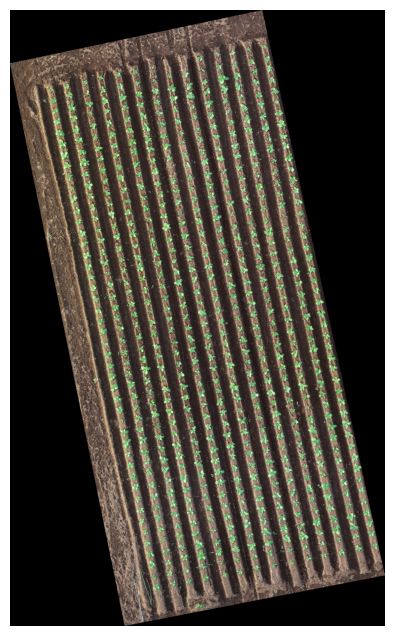

In [12]:
plot_multibands_fromxarray(fielddata.drone_data, bands = ['red', 'green', 'blue'], fig_sizex=5, fig_sizey=8, xinverse=False)

### Split into tiles

The second step was to divide each rgb image into tiles of sizes 512 x 512, this was done for making easier the labeling process.

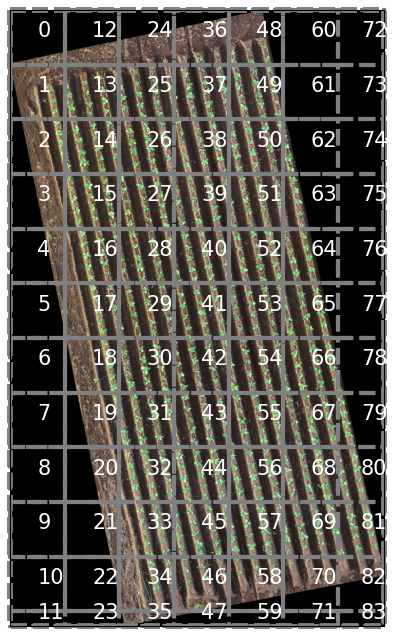

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle


threebanddata = []
for i in np.array(fielddata.drone_data.data_vars.variables):

    banddata = fielddata.drone_data[i].data
    banddata[banddata == fielddata.drone_data.attrs['nodata']] = np.nan
    threebanddata.append(scaleminmax(banddata))


fig,ax = plt.subplots(1, figsize=(5,8))

_, boxes = split_xarray_data(fielddata.drone_data, polygons = True,
                                width = 512, height = 512, overlap = 0)

arraypplot = np.array(threebanddata)

if(arraypplot.shape[0]==3):
    arraypplot  = np.moveaxis(arraypplot, 0, -1)


font = {'color':  'white',
        'weight': 'normal',
        'size': 15}

ax.imshow(arraypplot)

for i,box in boxes:
    if i % 1 == 0:
            
        xs, ys = box.exterior.xy 
        minx, miny, maxx, maxy =box.bounds
        width, height = abs(maxx - minx),  abs(miny-maxy)
        # Create a Rectangle patch
        rect = Rectangle( (minx,miny), width,height, linestyle = 'dashed', facecolor = 'None', 
                        clip_on=False,edgecolor='gray',lw=3)
        ax.add_patch(rect)
        #ax.fill(xs, ys, facecolor='none', color='--', linewidth=3)
        ax.text(xs[0] + (xs[2] - xs[0])/2,ys[0] + (ys[2] - ys[0])/2,str(i), fontdict=font)
        ax.set_xticks([])
        ax.set_yticks([])

    rect = Rectangle( (0,0), arraypplot.shape[1], arraypplot.shape[0], linestyle = 'dashed', facecolor = 'None', 
                        clip_on=False,edgecolor='gray',lw=3)
    ax.add_patch(rect)

In [61]:
### Single tile example

fielddata.split_into_tiles(width = 512, height = 512, overlap = 0) 
tileid = 43
plot_multibands_fromxarray(fielddata.tiles_data(69), bands = ['red', 'green', 'blue'], fig_sizex=4, fig_sizey=4)

the image was divided into 84 tiles


### Imagery export

The tiles information was exported as JPG an the it was uploaded into the Roboflow platform for manually drawing the boujnding boxes.

In [19]:
## export individuals images as JPG

### export as png
outputfolder = "/content/tanashi_2021_tiles_512/"

if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

for fimg in [imgdate1]:
    
    fielddata  = drone_data.DroneData(fimg, multiband_image=True, bounds = roi)
    fielddata.split_into_tiles(width = 512, height = 512, overlap = 0) 
    
    date = find_date_instring(fimg, pattern = '21', yearformat = 'yy')
    for i in range(0,len(fielddata._tiles_pols)):
        
        filename = os.path.join(outputfolder, "imgs_{}_tile_{}.jpg".format(date,i))
        data_tile = from_xarray_2_rgbimage(fielddata.tiles_data(i),
                                        export_as_jpg=True,
                                        ouputpath=filename)
        

the image was divided into 84 tiles


/content/drone_data/utils/data_processing.py:183: RuntimeWarning: invalid value encountered in true_divide
  banddata = (banddata *255)/ np.nanmax(banddata)


### Roboflow

Once the tiles were exported as an image, they were uploaded into Roboflow. This is a user-friendly platform for manually drawing images to be used for training. The following steps will require that you download the imagery after being labeled, this information is located in RoboFlow [link](https://universe.roboflow.com/andres-u8hev/tanashipaper/dataset/1).


In [40]:
import requests
import zipfile
outputpath = '/content/labeled_imagery'
## donwload images
url = 'https://universe.roboflow.com/ds/ECVgXBRGCC?key=jOFoua2HF9'
r = requests.get(url, allow_redirects=True)
fn = r.headers.get('content-disposition')
filename = fn[fn.index("filename=")+len("filename=")+1:fn.index(".zip")] +'.zip'
open(os.path.join('/content/',filename), 'wb').write(r.content)

## unzip
with zipfile.ZipFile(os.path.join('/content/',filename), 'r') as zip:
    zip.extractall(outputpath)



### Model's training

The images uploaded to roboflow belongs to the field denoted as training. But for intenal validation, we separate 15% of the data for validation.
 

In [49]:
from drone_data.ImagesTransform.image_processing import ImageData
from drone_data.ImagesTransform.general_functions import get_ids_split_datasets

RAWIMAGESPATH = "/content/labeled_imagery/train/"

imgs_data = ImageData(RAWIMAGESPATH, 
                      image_size = (10, 10))

100%|██████████| 547/547 [00:04<00:00, 111.73it/s]


In [50]:
### 
val_percentage = 15
test_percentage = 0
ntotal = len(imgs_data.images_data['raw'])
idssplit = get_ids_split_datasets(ntotal, val_perc=val_percentage,test_perc=test_percentage)

print(f"""Total training images: {len(idssplit[0])}
Total validation: {len(idssplit[1])}""")


Total training images: 465
Total validation: 82


#### Data augmentation

To augment the data that is gonnabe used for training, we applied 3 different algorithms that modified the images:
-   Rotation
-   Image zooming
-   Color change

['/content/labeled_imagery/train/images/imgs_20211006_tile_32_jpg.rf.e24795566c03673e85c23e2026b6c54e.jpg']


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

1 were added to images data
1 were added to images data


1 were added to images data


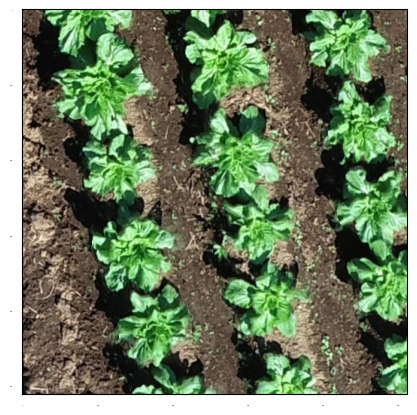

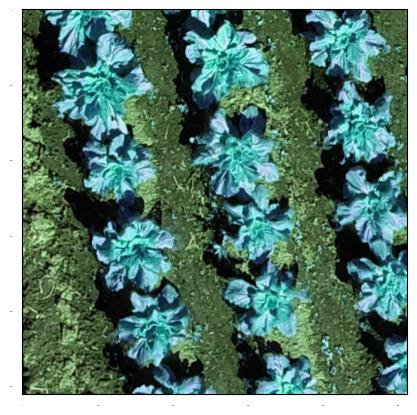

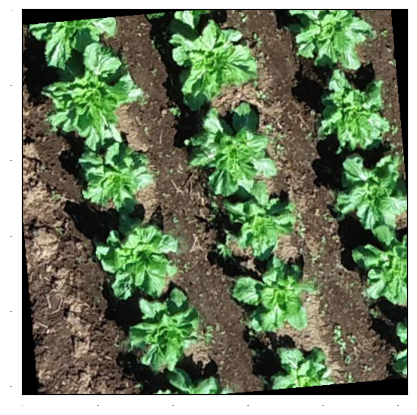

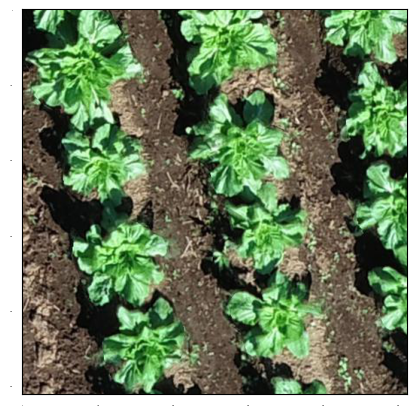

In [78]:
## output folder

outputfolder = '/content/yolo_imagery'
if not os.path.exists(outputfolder):
  os.mkdir(outputfolder)

imgs_datatraining = ImageData(RAWIMAGESPATH,
                              id_image=20)

imgs_datatraining.aug_change_hsv(['raw'], hue_shift = list(range(-50,50,5)), sat_shift = list(range(-25,25,5)), val_shift = list(range(-25,25,5)))
imgs_datatraining.aug_rotate_image(['raw'], angle = list(range(-265,270,90)))
imgs_datatraining.aug_expand_image(['raw'],ratio = list(range(-14,0,7)))
iddata = 0
imgs_datatraining.plot_image(iddata,sourcetype='raw', add_label=True, figsize=(5,5))
imgs_datatraining.plot_image(iddata,sourcetype='hsv', add_label=True, figsize=(5,5))
imgs_datatraining.plot_image(iddata,sourcetype='rotate', add_label=True, figsize=(5,5))
imgs_datatraining.plot_image(iddata,sourcetype='expand', add_label=True, figsize=(5,5))


####  Export new images created with data augmentation


In [46]:

## export training

imgs_datatraining = ImageData(RAWIMAGESPATH, 
                              id_image=list(idssplit[0]))

imgs_datatraining.aug_change_hsv(['raw'], hue_shift = list(range(-25,25,5)), sat_shift = list(range(-25,25,5)), val_shift = list(range(-25,25,5)))
imgs_datatraining.aug_rotate_image(['raw'], angle = list(range(-265,270,90)))
imgs_datatraining.aug_expand_image('rotate',samplesize = 60, ratio = list(range(-14,14,7)))

fout = os.path.join(outputfolder,'training')
if not os.path.exists(fout):
    os.makedirs(fout)
imgs_datatraining.to_jpg(output_path=os.path.join(outputfolder,'training'), size= (512,512))




['/content/labeled_imagery/train/images/imgs_20210929_tile_51_jpg.rf.6801564fc5d34fcf7f7f3406416893f3.jpg', '/content/labeled_imagery/train/images/imgs_20210929_tile_45_jpg.rf.a5b4c2d3b115b83f308822476c65e44d.jpg', '/content/labeled_imagery/train/images/imgs_20211004_tile_15_jpg.rf.a33a5893c5051cdc4685a5b104b66ccb.jpg', '/content/labeled_imagery/train/images/imgs_20210929_tile_68_jpg.rf.11480de56941168e9694b0b67f7813d6.jpg', '/content/labeled_imagery/train/images/imgs_20211004_tile_1_jpg.rf.c1105e076f41a4abda05fcdc4d3b3f90.jpg', '/content/labeled_imagery/train/images/imgs_20211006_tile_46_jpg.rf.8d6fca16e3e84f6a6c14ff6f77a2ba7f.jpg', '/content/labeled_imagery/train/images/imgs_20211006_tile_37_jpg.rf.0a96245845fbff9cde02773e5ea303c3.jpg', '/content/labeled_imagery/train/images/imgs_20211004_tile_13_jpg.rf.580de082a0b1bfc9c4416cd08eb3aebc.jpg', '/content/labeled_imagery/train/images/imgs_20211006_tile_29_jpg.rf.79c6dfe1a57633d1841be43a8b37f93a.jpg', '/content/labeled_imagery/train/image

100%|██████████| 130/130 [00:31<00:00,  4.13it/s]


130 were added to images data
130 were added to images data
78 were added to images data


In [47]:
## export validation 

imgs_datavalidation = ImageData(RAWIMAGESPATH, 
                              id_image=list(idssplit[1]))

imgs_datavalidation.aug_change_hsv(['raw'], hue_shift = list(range(-25,25,5)), sat_shift = list(range(-25,25,5)), val_shift = list(range(-25,25,5)))
imgs_datavalidation.aug_rotate_image(['raw'], angle = list(range(-270,270,90)))
imgs_datavalidation.aug_expand_image('rotate',samplesize = 60, ratio = [-5,-10,5,10])

fout = os.path.join(outputfolder,'validation')
if not os.path.exists(fout):
    os.makedirs(fout)
imgs_datavalidation.to_jpg(output_path=os.path.join(outputfolder,'validation'), size= (512,512))

['/content/labeled_imagery/train/images/imgs_20211006_tile_44_jpg.rf.acf5c65918c11a5db35dcc495391c2b3.jpg', '/content/labeled_imagery/train/images/imgs_20210929_tile_64_jpg.rf.60ac336f0072e0a54508c0bf0d2e7bac_rotate_185.jpg', '/content/labeled_imagery/train/images/imgs_20211004_tile_38_jpg.rf.3f769285f0f91ce73b815afacfeb1ff9_rotate_185.jpg', '/content/labeled_imagery/train/images/imgs_20210929_tile_82_jpg.rf.45f10003e744f6e68be830d7fbc09309_hsv_-15_10_10.jpg', '/content/labeled_imagery/train/images/imgs_20211004_tile_67_jpg.rf.648932c21490f665a122bc8ea3c5abba_hsv_20_-20_0.jpg', '/content/labeled_imagery/train/images/imgs_20211004_tile_34_jpg.rf.500f238a5c4f3d2dd09a9406a8bbfc65_rotate_95.jpg', '/content/labeled_imagery/train/images/imgs_20211006_tile_46_jpg.rf.8d6fca16e3e84f6a6c14ff6f77a2ba7f_rotate_-265_expand_-14.jpg', '/content/labeled_imagery/train/images/imgs_20210929_tile_55_jpg.rf.b181557f0864111ccde81bda0b53d920_hsv_10_-10_-5.jpg', '/content/labeled_imagery/train/images/imgs_202

100%|██████████| 22/22 [00:03<00:00,  6.06it/s]


22 were added to images data
22 were added to images data
13 were added to images data


In [51]:
##### export yaml file: this file used for yolo training

trainingfolder = os.path.join(outputfolder, "training/images").replace('\\','/')
valfolder = os.path.join(outputfolder, "validation/images").replace('\\','/')
ncategories = 1
namecategori = ['chcabbage']

with open(os.path.join(outputfolder,"data.yaml"), 'w') as dst:
    dst.write("train: {}\nval: {}\n\nnc: {}\nnames: {}".format(
        trainingfolder,
        valfolder,
        ncategories,
        namecategori
    ))
    

In [52]:
### read total training boundaing boxes

import os
import numpy as np
paths = '/content/yolo_imagery/training/labels'
filestoread = os.listdir(paths)

totallines = []
for fn in range(len(filestoread)):
    with open(os.path.join(paths,filestoread[fn]), 'r') as fp:
        x = len(fp.readlines())
        totallines.append(x)
        #print('Total lines:', x) # 8

print("Total bounding boxes: {}".format(np.array(totallines).sum()))

### YOLO training

Once was set up all the training dataset, next step is to train the model



In [77]:
!pip install -r yolov5/requirements.txt

'/content'

In [ ]:
import torch
import os
dateset_path = "/content/yolo_imagery/training/"
odpath = 'yolov5'"../drone_data/models/cc_tanashi_v2/weights/best.pt"

In [ ]:
!python \conent\yolov5\train.py --workers 1 --img 512 --batch 4 --epochs 300 --data \content\yolo_imagery\data.yaml --weights \content\weigths\best.pt --cache 

^C


train: weights=..\drone_data\model\cc_tanashi_v2\weights\best.pt, cfg=, data=training_images\merged\data.yaml, hyp=yolov5\data\hyps\hyp.scratch-low.yaml, epochs=300, batch_size=4, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=1, project=yolov5\runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
From https://github.com/ultralytics/yolov5
   342fe05..443ef7f  master     -> origin/master
   c6323b2..d371b16  exp13      -> origin/exp13
github:  YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
requirements: YOLOv5 requirement "thop>=0.1.1" not found, attempting AutoUpda

### Individual plant detection

Once that the model was trained, we will be able to use yolo's model for detecting chinese cabbage. In this case we will use the weights that were obtained for the paper.

In [53]:
## setting yolo model
import sys
import os 
sys.path.append(os.path.join(os.getcwd(), 'yolov5'))


In [56]:
from yolov5.utils.torch_utils import select_device
from yolov5.models.common import DetectMultiBackend
## setting device
device = select_device()
## loading model

weights = "/content/best.pt"

model = DetectMultiBackend(weights, device=device)

YOLOv5 🚀 v7.0-169-geef637c Python-3.10.11 torch-2.0.1+cu118 CPU

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients


In [57]:
from drone_data.utils.od_functions import DroneObjectDetection

In [59]:
### reading data
import geopandas as gpd

roi = gpd.read_file('/content/tanashi_field.shp')
TP1IMAGEPATH = "/content/tana_cc_rgb_210927_transparent_mosaic_group1.tif"

drdata = DroneObjectDetection(TP1IMAGEPATH, yolo_model= model, device = device, multiband_image=True, bounds = roi)

the image was divided into 156 tiles


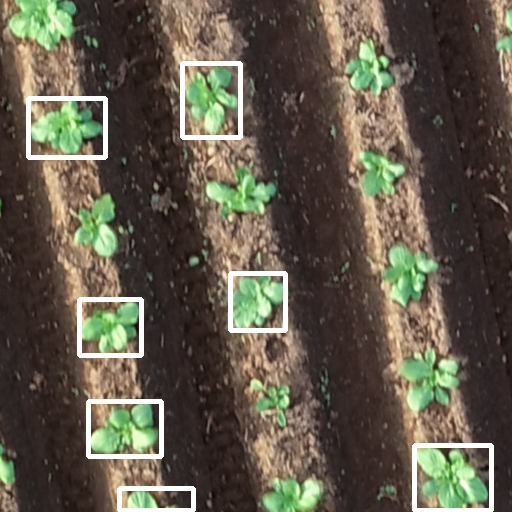

In [71]:
%matplotlib inline
import torch
from PIL import Image
import numpy as np

idtile = 43
drdata.split_into_tiles(width = 512, height = 512, overlap = 0) 
imgdraw = drdata.draw_bb_in_tile(drdata.tiles_data(idtile))
Image.fromarray(np.uint8(imgdraw))

#plt.imshow(imgdraw/255.)


In [72]:
## detecting all bounding boxes in the image

allbb = drdata.detect_oi_in_uavimage(imgsize = 512, overlap = [0,0.2], aoi_limit = 0.5, onlythesetiles = None, conf_thres=0.50)

the image was divided into 156 tiles


100%|██████████| 156/156 [00:50<00:00,  3.08it/s]


the image was divided into 240 tiles


100%|██████████| 240/240 [01:22<00:00,  2.90it/s]


the image was divided into 420 tiles


100%|██████████| 420/420 [02:09<00:00,  3.23it/s]


4458 polygons were detected
965 boundary boxes were detected


<Axes: >

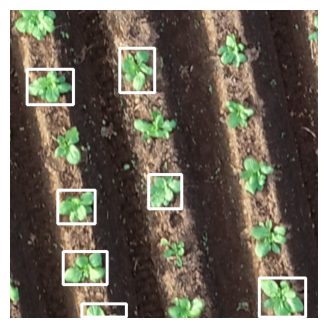

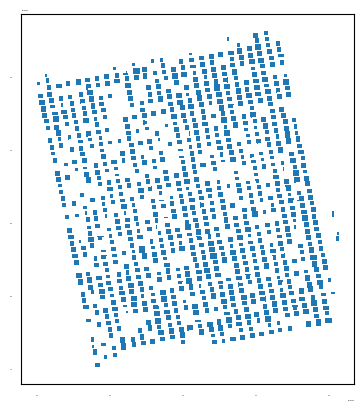

In [75]:
## the output is a geopandas dataframe which can be exported as shp vector
allbb.plot()
allbb.to_file('/content/bb_predictions.shp')